In [ ]:
from radas import run_experiment, get_ray_results_dir  # pyright: ignore[reportMissingImports]
import ray.tune as tune
from v10_1_backprop_baseline import trainable_backprop
import torch
import pandas as pd
import numpy as np


results = await run_experiment(
    user_name="mengfan",
    experiment_name="BP的baseline实验",
    param_space=dict(
        seed = tune.grid_search([1,2,3,4,5,6,7,8,9,10]),  
        # alpha_gen = tune.grid_search([round(x, 2) for x in np.arange(0, 0.11, 0.01)]),
        # alpha_disc = tune.grid_search([round(x, 1) for x in np.arange(0.1, 1.01, 0.1)]),
        epochs = tune.grid_search([100]),

    ),
    # IMPORTANT: when using cluster, your trainable cannot be defined in this script, but has to be defined in a separate file, and imported in this script
    trainable=trainable_backprop,
    # When use cluster, local_storage_path needs to be specified in this way
    local_storage_path=get_ray_results_dir(),
    # Specify the cluster to use
    run_with="cluster:atol-gpu-5090",
    # Specify gram per trial
    cpu_per_trial=1,
    # If the gram_per_trial you set is larger than GRAM of a single GPU, you will be allocated with more than one GPUs
    # to fit your need. But in this case, you will need to handle how do you want to distribute your workload to these multiple GPUs
    # To check GRAM of a single GPU, use the following code:
    # from radas.clusters import gram_per_gpu
    #
    runtime_env={
        "pip": ["emoji","scikit-learn"],
        # for more runtime_env specifications, see https://docs.ray.io/en/latest/ray-core/handling-dependencies.html#api-reference
    },
    #
    instant_gpu_allocation=1,
)

[INFO]: Checking if the experiment exists...
[Choices]: Choose an option by number:
[1]: run -- Run a new experiment (if there is a running experiment, it will be stopped; if there is a existing experiment in the storage, it will be removed)
 2 : restore -- Restore an existing experiment from the storage (if there is a running experiment, it will be stopped)
 3 : attach -- Attach to a running experiment
 4 : stop_attach -- Stop and attach to a running experiment
>>> [1]: Run a new experiment (if there is a running experiment, it will be stopped; if there is a existing experiment in the storage, it will be removed)
[INFO]: 🚀 正在测试代理连接...
[INFO]: ✅ 代理连接成功


2025-12-25 21:57:37,761	INFO dashboard_sdk.py:355 -- Uploading package gcs://_ray_pkg_e7cd976e0f10815e.zip.
2025-12-25 21:57:37,762	INFO packaging.py:588 -- Creating a file package for local module '/mnt/data/home/mengfan/projects/BiPCN/BiPCN/v10'.
2025-12-25 21:57:37,815	INFO dashboard_sdk.py:355 -- Uploading package gcs://_ray_pkg_4588c91f8f921f3a.zip.
2025-12-25 21:57:37,816	INFO packaging.py:588 -- Creating a file package for local module '/mnt/data/home/mengfan/repos/radas/radas/'.


[INFO]: Submitting job...
[INFO]: Job submitted.
[INFO]: Tailing experiment logs below 👇👇👇
2025-12-25 08:57:37,900	INFO job_manager.py:531 -- Runtime env is setting up.

  0%|          | 0/9 [00:00<?, ?file/s]
rm_local_folder: mengfan/关于比例的最终实验/trainable_46916_00000_0_epochs=100,seed=1_2025-12-25_08-47-38/events.out.tfevents.1766670468.atol-gpu-5090-head:   0%|          | 0/9 [00:00<?, ?file/s]
rm_local_folder: mengfan/关于比例的最终实验/trainable_46916_00000_0_epochs=100,seed=1_2025-12-25_08-47-38/result.json:   0%|          | 0/9 [00:00<?, ?file/s]                                      
rm_local_folder: mengfan/关于比例的最终实验/trainable_46916_00000_0_epochs=100,seed=1_2025-12-25_08-47-38/params.json:   0%|          | 0/9 [00:00<?, ?file/s]
rm_local_folder: mengfan/关于比例的最终实验/trainable_46916_00000_0_epochs=100,seed=1_2025-12-25_08-47-38/params.pkl:   0%|          | 0/9 [00:00<?, ?file/s] 
rm_local_folder: mengfan/关于比例的最终实验/.validate_storage_marker:   0%|          | 0/9 [00:00<?, ?file/s]              

In [15]:
results["df"]
df = results["df"]

Available epoch metrics: ['test_acc', 'test_loss', 'train_loss']


ValueError: No columns for metric='E_train_after_infer'. Expected epoch_k/E_train_after_infer

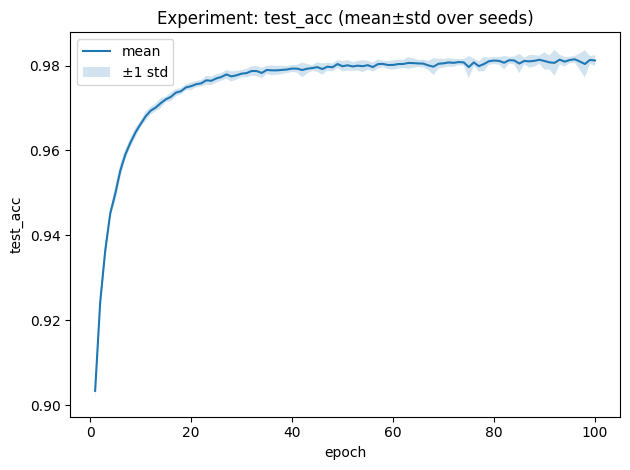

In [16]:
from v10_1_visual import plot_experiment_results
plot_experiment_results(df)

In [17]:
results["df"]


,device,torch.cuda.is_available,config/method,config/seed,config/batch_size,config/epochs,config/layers,config/activation,config/negative_slope,config/use_bias,...,epoch_99/test_loss,epoch_99/test_acc,epoch_100/train_loss,epoch_100/test_loss,epoch_100/test_acc,final/test_acc,final/train_loss,final/test_loss,training_iteration,config/experiment_name
0,cuda,True,backprop,1,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.078788,0.9823,0.000395,0.078736,0.9821,0.9821,0.000395,0.078736,1,关于比例的最终实验
1,cuda,True,backprop,10,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.086278,0.9806,0.000333,0.089148,0.9809,0.9809,0.000333,0.089148,1,关于比例的最终实验
2,cuda,True,backprop,8,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.086333,0.9809,0.000329,0.089358,0.9808,0.9808,0.000329,0.089358,1,关于比例的最终实验
3,cuda,True,backprop,9,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.090757,0.9810,0.000379,0.091903,0.9807,0.9807,0.000379,0.091903,1,关于比例的最终实验
4,cuda,True,backprop,4,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.082199,0.9831,0.000332,0.082964,0.9827,0.9827,0.000332,0.082964,1,关于比例的最终实验
5,cuda,True,backprop,2,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.092948,0.9808,0.000637,0.091840,0.9824,0.9824,0.000637,0.091840,1,关于比例的最终实验
6,cuda,True,backprop,5,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.084053,0.9819,0.000321,0.083806,0.9816,0.9816,0.000321,0.083806,1,关于比例的最终实验
7,cuda,True,backprop,6,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.093521,0.9801,0.000339,0.091993,0.9807,0.9807,0.000339,0.091993,1,关于比例的最终实验
8,cuda,True,backprop,3,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.087019,0.9806,0.005404,0.104569,0.9783,0.9783,0.005404,0.104569,1,关于比例的最终实验
9,cuda,True,backprop,7,256,100,"[784, 256, 256, 10]",leaky_relu,0.01,True,...,0.080472,0.9819,0.000437,0.080648,0.9817,0.9817,0.000437,0.080648,1,关于比例的最终实验


In [21]:
final_test_acc_col = df["final/test_acc"]
print(final_test_acc_col)
# 算一个平均值
final_test_acc_mean = final_test_acc_col.mean()
print(final_test_acc_mean)
# 算一个标准差
final_test_acc_std = final_test_acc_col.std()
print(final_test_acc_std)


0    0.9821
1    0.9809
2    0.9808
3    0.9807
4    0.9827
5    0.9824
6    0.9816
7    0.9807
8    0.9783
9    0.9817
Name: final/test_acc, dtype: float64
0.9811900000000001
0.0012502888555139054
